In [100]:
import os
import pandas as pd
from web3 import Web3
import matplotlib.pyplot as plt
import seaborn as sns
from web3.types import LogReceipt, TxData
from dotenv import load_dotenv

load_dotenv()
BADGER_TOKEN_ADDRESS = '0x4b92d19c11435614cd49af1b589001b7c08cd4d5'

def get_approvals(w3: Web3) -> list[LogReceipt]:
    transfer_event_hash = Web3.keccak(text='Approval(address,address,uint256)')

    return w3.eth.get_logs({'address': Web3.to_checksum_address(BADGER_TOKEN_ADDRESS), 'topics':[transfer_event_hash], 'fromBlock': 13133845, 'toBlock': 13916631})

infura_url = os.getenv("INFURA_URL")
infura_api_key = os.getenv("INFURA_API_KEY")
w3 = Web3(Web3.HTTPProvider(f'{infura_url}/{infura_api_key}'))

# Call get_approvals function with provided address
approval_list = get_approvals(w3)
approval: LogReceipt
df = pd.DataFrame(map(lambda approval: {
    'token_contract_address': approval.address,
    'transaction_hash': approval.transactionHash.hex(),
    'amount_of_tokens': int.from_bytes(approval.data, byteorder="big"),
    'from_user': '0x' + approval.topics[1].hex()[-40:],
    'spender': '0x' + approval.topics[2].hex()[-40:],
    'block_number': approval.blockNumber
}, approval_list))

print(len(approval_list))
df.head()

169


,token_contract_address,transaction_hash,amount_of_tokens,from_user,spender,block_number
0,0x4b92d19c11435614CD49Af1b589001b7c08cD4D5,0x9d98fcddc08faeac0a77a16a25d93e0954d20200cc20...,1157920892373161954235709850086879078532699846...,0xd494033aecb97d4ff84b7fb2be33e76fed69f66a,0x825218bed8be0b30be39475755acee0250c50627,13137909
1,0x4b92d19c11435614CD49Af1b589001b7c08cD4D5,0x31c22e6db256ef484bbd182eb16aa0e65e3c75a90db7...,1157920892373161954235709850086879078532699846...,0xcefcca169357a18eb8c3f230f92b58562e48cae5,0x825218bed8be0b30be39475755acee0250c50627,13138156
2,0x4b92d19c11435614CD49Af1b589001b7c08cD4D5,0xb59727e020879a6af38c87c24a75fb57838f4abde823...,1157920892373161954235709850086879078532699846...,0xcefcca169357a18eb8c3f230f92b58562e48cae5,0x825218bed8be0b30be39475755acee0250c50627,13138169
3,0x4b92d19c11435614CD49Af1b589001b7c08cD4D5,0x50250b6ab72eab02a53245f330b07e8eb2f16a6b883a...,1157920892373161954235709850086879078532699846...,0xcefcca169357a18eb8c3f230f92b58562e48cae5,0x825218bed8be0b30be39475755acee0250c50627,13138182
4,0x4b92d19c11435614CD49Af1b589001b7c08cD4D5,0x4aa7ecd573844af42eb76b745c46aa0f96366a511b2f...,1157920892373161954235709850086879078532699846...,0x8f9f67770c8cbfff7d5748d15996dc1cfb2fc5fc,0x825218bed8be0b30be39475755acee0250c50627,13156680


                                      spender  count  is_contract
0  0x825218bed8be0b30be39475755acee0250c50627     82         True
1  0x27fb47b9fb32b9cf660c4e0128be0f4e883f3df1     37         True
2  0x1fcdb04d0c5364fbd92c73ca8af9baa72c269107     31        False
3  0xb6ea1d3fb9100a2cf166febe11f24367b5fcd24a     11         True
4  0x155482d1e2cb0909333326504f0ea4350760c927      6         True
5  0x91d65d67fc573605bcb0b5e39f9ef6e18afa1586      2        False


/var/folders/_z/k3js06p17z74qnycqfwv10hr0000gn/T/ipykernel_10462/2748044889.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='spender', y='count', data=spender_counts.head(100), palette=colors)


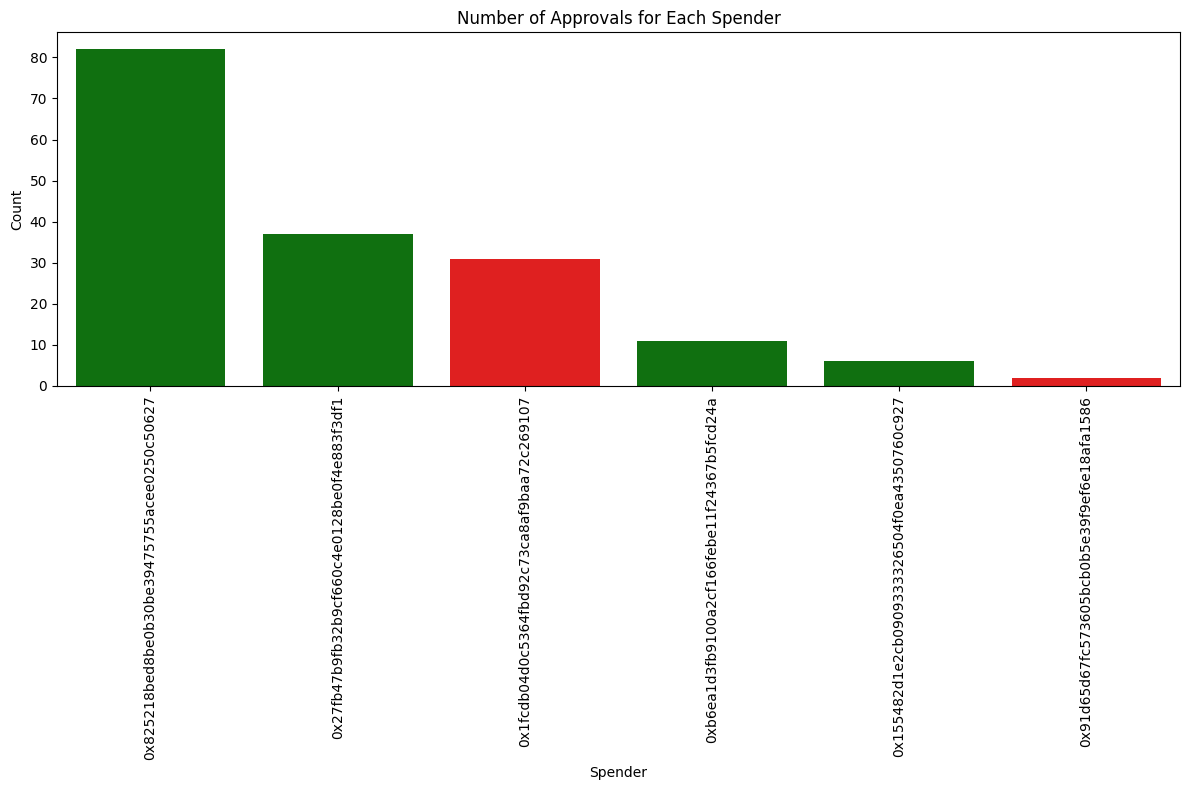

In [101]:
spender_counts = df['spender'].value_counts().reset_index()
spender_counts.columns = ['spender', 'count']
spender_counts['is_contract'] = spender_counts.apply(lambda row: w3.eth.get_code(w3.to_checksum_address(row.spender)).hex() > hex(0), axis=1)
print(spender_counts.head(10))

import matplotlib.pyplot as plt
import seaborn as sns

colors = ['green' if is_contract else 'red' for is_contract in spender_counts['is_contract']]
plt.figure(figsize=(12, 8))
sns.barplot(x='spender', y='count', data=spender_counts.head(100), palette=colors)
plt.title('Number of Approvals for Each Spender')
plt.xlabel('Spender')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [90]:
spender_unique_from_users = df.groupby('spender')['from_user'].nunique().reset_index()
spender_unique_from_users.columns = ['spender', 'unique_from_users']
spender_unique_from_users.head(10)

,spender,unique_from_users
0,0x10eaaca8e8b5cf1ed0949e060790c62d6f8f39b8,1
1,0x155482d1e2cb0909333326504f0ea4350760c927,308
2,0x1fcdb04d0c5364fbd92c73ca8af9baa72c269107,12
3,0x27fb47b9fb32b9cf660c4e0128be0f4e883f3df1,25
4,0x41671ba1abcba387b9b2b752c205e22e916be6e3,1
5,0x4718fc7e40092a9d5fc584699aea1aa4c6f63d33,1
6,0x825218bed8be0b30be39475755acee0250c50627,495
7,0x91d65d67fc573605bcb0b5e39f9ef6e18afa1586,1
8,0xb6ea1d3fb9100a2cf166febe11f24367b5fcd24a,31


In [61]:
erc20_abi = [
    {
        "anonymous": False,
        "inputs": [
            {"indexed": True, "name": "owner", "type": "address"},
            {"indexed": True, "name": "spender", "type": "address"},
            {"indexed": False, "name": "value", "type": "uint256"}
        ],
        "name": "Approval",
        "type": "event"
    },
    {
        "constant": True,
        "inputs": [{"name": "_owner", "type": "address"}],
        "name": "balanceOf",
        "outputs": [{"name": "balance", "type": "uint256"}],
        "payable": False,
        "stateMutability": "view",
        "type": "function"
    }
]

# Instantiate the ERC20 contract
erc20_contract = w3.eth.contract(address=w3.to_checksum_address(BADGER_TOKEN_ADDRESS), abi=erc20_abi)

In [66]:
df['exposer'] = df.apply(lambda row: erc20_contract.functions.balanceOf(w3.to_checksum_address(row.from_user)).call(block_identifier=row.block_number), axis=1)
df.head()


,token_contract_address,transaction_hash,amount_of_tokens,from_user,spender,block_number,exposer
0,0x4b92d19c11435614CD49Af1b589001b7c08cD4D5,0x9d98fcddc08faeac0a77a16a25d93e0954d20200cc20...,1157920892373161954235709850086879078532699846...,0xd494033aecb97d4ff84b7fb2be33e76fed69f66a,0x825218bed8be0b30be39475755acee0250c50627,13137909,0
1,0x4b92d19c11435614CD49Af1b589001b7c08cD4D5,0x31c22e6db256ef484bbd182eb16aa0e65e3c75a90db7...,1157920892373161954235709850086879078532699846...,0xcefcca169357a18eb8c3f230f92b58562e48cae5,0x825218bed8be0b30be39475755acee0250c50627,13138156,0
2,0x4b92d19c11435614CD49Af1b589001b7c08cD4D5,0xb59727e020879a6af38c87c24a75fb57838f4abde823...,1157920892373161954235709850086879078532699846...,0xcefcca169357a18eb8c3f230f92b58562e48cae5,0x825218bed8be0b30be39475755acee0250c50627,13138169,0
3,0x4b92d19c11435614CD49Af1b589001b7c08cD4D5,0x50250b6ab72eab02a53245f330b07e8eb2f16a6b883a...,1157920892373161954235709850086879078532699846...,0xcefcca169357a18eb8c3f230f92b58562e48cae5,0x825218bed8be0b30be39475755acee0250c50627,13138182,0
4,0x4b92d19c11435614CD49Af1b589001b7c08cD4D5,0x4aa7ecd573844af42eb76b745c46aa0f96366a511b2f...,1157920892373161954235709850086879078532699846...,0x8f9f67770c8cbfff7d5748d15996dc1cfb2fc5fc,0x825218bed8be0b30be39475755acee0250c50627,13156680,5012147


In [68]:
df.transaction_hash[0]

'0x9d98fcddc08faeac0a77a16a25d93e0954d20200cc208e434aa23550fdcb6b13'